In [1]:
#Dependencies
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as skl
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import re
import time,ciso8601
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy import stats

# Loading model and historical stock data

In [2]:
#Loading John Stockton model
John_Stockton_Model=tf.keras.models.load_model("John_Stockton_Model.h5")

In [3]:
#Tester stock, decided to use Tesla
stock = yf.Ticker("TSLA")
stock

yfinance.Ticker object <TSLA>

# Data Preprocessing

## From converting dates to timestamps to changing structure of stock data

In [4]:
#Create a function that converts dates to timestamps
def to_timestamp(date):
    return int(datetime.datetime.strptime(str(date.date()), "%Y-%m-%d").timestamp())

In [5]:
#History of the stock for 3 years starting 2019
stock_df= stock.history(interval="1d", start="2019-01-01", end="2022-01-01").reset_index()

In [6]:
#Converting the dates to timestamps to make it much easier to graph
stock_timestamps=[]
for dates in stock_df["Date"]:
    stock_timestamps.append(to_timestamp(dates))
stock_df["timestamps"]=stock_timestamps
stock_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,timestamps
0,2019-01-02 00:00:00-05:00,20.406668,21.008667,19.920000,20.674667,174879000,0.0,0.0,1546416000
1,2019-01-03 00:00:00-05:00,20.466667,20.626667,19.825333,20.024000,104478000,0.0,0.0,1546502400
2,2019-01-04 00:00:00-05:00,20.400000,21.200001,20.181999,21.179333,110911500,0.0,0.0,1546588800
3,2019-01-07 00:00:00-05:00,21.448000,22.449333,21.183332,22.330667,113268000,0.0,0.0,1546848000
4,2019-01-08 00:00:00-05:00,22.797333,22.934000,21.801332,22.356667,105127500,0.0,0.0,1546934400
...,...,...,...,...,...,...,...,...,...
752,2021-12-27 00:00:00-05:00,357.890015,372.333344,356.906677,364.646667,71145900,0.0,0.0,1640592000
753,2021-12-28 00:00:00-05:00,369.829987,373.000000,359.473328,362.823334,60324000,0.0,0.0,1640678400
754,2021-12-29 00:00:00-05:00,366.213318,368.000000,354.713318,362.063324,56154000,0.0,0.0,1640764800
755,2021-12-30 00:00:00-05:00,353.776672,365.183319,351.049988,356.779999,47040900,0.0,0.0,1640851200


In [7]:
#Get stocks from the nasdaq 500
nasdaq_df = pd.read_csv("nasdaq500.csv")
nasdaq_df

,Symbol,Name,Sector
0,MMM,3M Co.,Industrials
1,ACE,ACE Limited,Financials
2,ABT,Abbott Laboratories,Health Care
3,ANF,Abercrombie & Fitch Company A,Consumer Discretionary
4,ACN,Accenture,Information Technology
...,...,...,...
495,XYL,Xylem Inc.,Industrials
496,YHOO,Yahoo Inc.,Information Technology
497,YUM,Yum! Brands Inc,Consumer Discretionary
498,ZMH,Zimmer Holdings,Health Care


In [8]:
# Function to retrieve historical stock data for a list of tickers and prepare a DataFrame
# Focuses on timestamps and close prices, with an additional column indicating whether the final outcome is positive or negative
def horizontal_stock_df1():
    # Grab tickers from the nasdaq_df
    tickers = nasdaq_df["Symbol"]
    
    # Create an empty pandas dataframe
    dataframe = pd.DataFrame({})
    
    # Loop through the tickers
    for ticker in tickers:
        try:
            # Fetch historical stock data for the current ticker
            stonk = yf.Ticker(ticker)
            stonk_df = stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            dict_ = {"Ticker": ticker}
            dates = stonk_df["Date"]
            price = stonk_df["Close"]
            
            # Populate the dictionary with timestamps and close prices
            for i in range(len(dates)):
                dict_[to_timestamp(dates[i])] = price[i]
            
            # Fetch additional stock data for a specific date range
            final_stock_df = stock.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()
            
            # Determine the final outcome based on the closing prices
            if price[len(price)-1] > final_stock_df['Close'][0]:
                dict_["Final_Outcome"] = 1
            else:
                dict_["Final_Outcome"] = 0
            
            # Concatenate the dictionary as a DataFrame to the main dataframe
            dataframe = pd.concat([dataframe, pd.DataFrame([dict_])])
        except:
            pass
    return dataframe

# Function to retrieve historical stock data for a single ticker within a specified date range
# Focuses on timestamps and close prices
def horizontal_stock_df3(ticker, start, end):
    # Create a Ticker object for the given stock symbol
    stock = yf.Ticker(ticker)
    
    # Fetch historical stock data within the specified date range
    stocks = stock.history(interval="1d", start=start, end=end).reset_index()
    
    # Create a dictionary to store timestamps and close prices
    dict_ = {"Ticker": ticker}
    dates = stocks["Date"]
    close = stocks["Close"]
    
    # Populate the dictionary with timestamps and close prices
    for i in range(len(dates)):
        dict_[to_timestamp(dates[i])] = close[i]
    
    # Convert the dictionary to a DataFrame and return
    return pd.DataFrame([dict_])

# Function to retrieve historical stock data for a list of tickers and prepare a DataFrame
# Focuses on timestamps and close prices, with an additional column indicating whether the final outcome is positive or negative
def horizontal_stock_df2(tickers):
    # Create an empty pandas dataframe
    dataframe = pd.DataFrame({})
    
    # Create a dictionary to store timestamps and close prices
    dict_ = {}
    
    # Loop through the tickers
    for ticker in tickers:
        try:
            # Fetch historical stock data for the current ticker
            stonk = yf.Ticker(ticker)
            stonk_df = stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            dates = stonk_df["Date"]
            price = stonk_df["Close"]
            
            # Populate the dictionary with timestamps and close prices
            for i in range(len(dates)):
                dict_[(dates[i])] = price[i]
            
            # Fetch additional stock data for a specific date range
            final_stock_df = stock.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()
            
            # Determine the final outcome based on the closing prices
            if price[len(price)-1] > final_stock_df['Close'][0]:
                dict_["Final_Outcome"] = 1
            else:
                dict_["Final_Outcome"] = 0
            
            # Concatenate the dictionary as a DataFrame to the main dataframe
            dataframe = pd.concat([dataframe, pd.DataFrame([dict_])])
        except:
            pass
    return dataframe.dropna()


In [9]:
# Function to retrieve historical stock data for a list of tickers and prepare a DataFrame
def horizontal_stock_df(tickers):
    # Create an empty pandas dataframe
    dataframe = pd.DataFrame({})
    
    # Loop through the tickers
    for ticker in tickers:
        try:
            # Fetch historical stock data for the current ticker
            stonk = yf.Ticker(ticker)
            stonk_df = stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            
            # Create a dictionary to store timestamps and close prices
            dict_ = {"Ticker": ticker}
            dates = stonk_df["Date"]
            price = stonk_df["Close"]
            
            # Populate the dictionary with timestamps and close prices
            for i in range(len(dates)):
                dict_[dates[i]] = price[i]
            
            # Fetch additional stock data for a specific date range
            final_stock_df = stonk.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()

            # Concatenate the dictionary as a DataFrame to the main dataframe
            dataframe = pd.concat([dataframe, pd.DataFrame([dict_])])
        except:
            # Skip to the next ticker if there's an exception (e.g., if data is not available)
            pass
    
    # Drop any rows with NaN values and the "Ticker" column
    return dataframe.dropna().drop(columns=["Ticker"])


# Functions for creating min and max matrix

In [10]:
# Function to find minimum values and corresponding dates within specified intervals across columns in a DataFrame
def mins(df, interval):
    # Lists to store minimum dates and values
    min_dates = []
    min_values = []
    
    # Counter variable to keep track of intervals
    count = 0
    
    # Loop through columns with the specified interval
    for i in range(0, len(df.columns)-interval, interval):
        # Extract a subarray of values from the DataFrame
        array = np.array(df[df.columns[i:i+interval]])
        
        # Append the minimum value to the list
        min_values.append(array.min())
        
        # Find the index of the minimum value and convert it to the corresponding date
        min_dates.append(to_timestamp(df.columns[interval * count + array.argmin()]))
        
        # Increment the counter
        count += 1
    
    # Return a tuple containing the lists of minimum dates and values
    return (min_dates, min_values)


In [11]:
# Function to find maximum values and corresponding dates within specified intervals across columns in a DataFrame
def maxs(df, interval):
    # Lists to store maximum dates and values
    max_dates = []
    max_values = []
    
    # Counter variable to keep track of intervals
    count = 0
    
    # Loop through columns with the specified interval
    for i in range(0, len(df.columns)-interval, interval):
        # Extract a subarray of values from the DataFrame
        array = np.array(df[df.columns[i:i+interval]])
        
        # Append the maximum value to the list
        max_values.append(array.max())
        
        # Find the index of the maximum value and convert it to the corresponding date
        max_dates.append(to_timestamp(df.columns[interval * count + array.argmax()]))
        
        # Increment the counter
        count += 1
    
    # Return a tuple containing the lists of maximum dates and values
    return (max_dates, max_values)


In [12]:
#Test the maxes on the tester stock
max_time, max_prices = maxs(horizontal_stock_df(["TSLA"]),10)

In [13]:
#Test the mins on the tester stock
min_time, min_prices = mins(horizontal_stock_df(["TSLA"]),10)

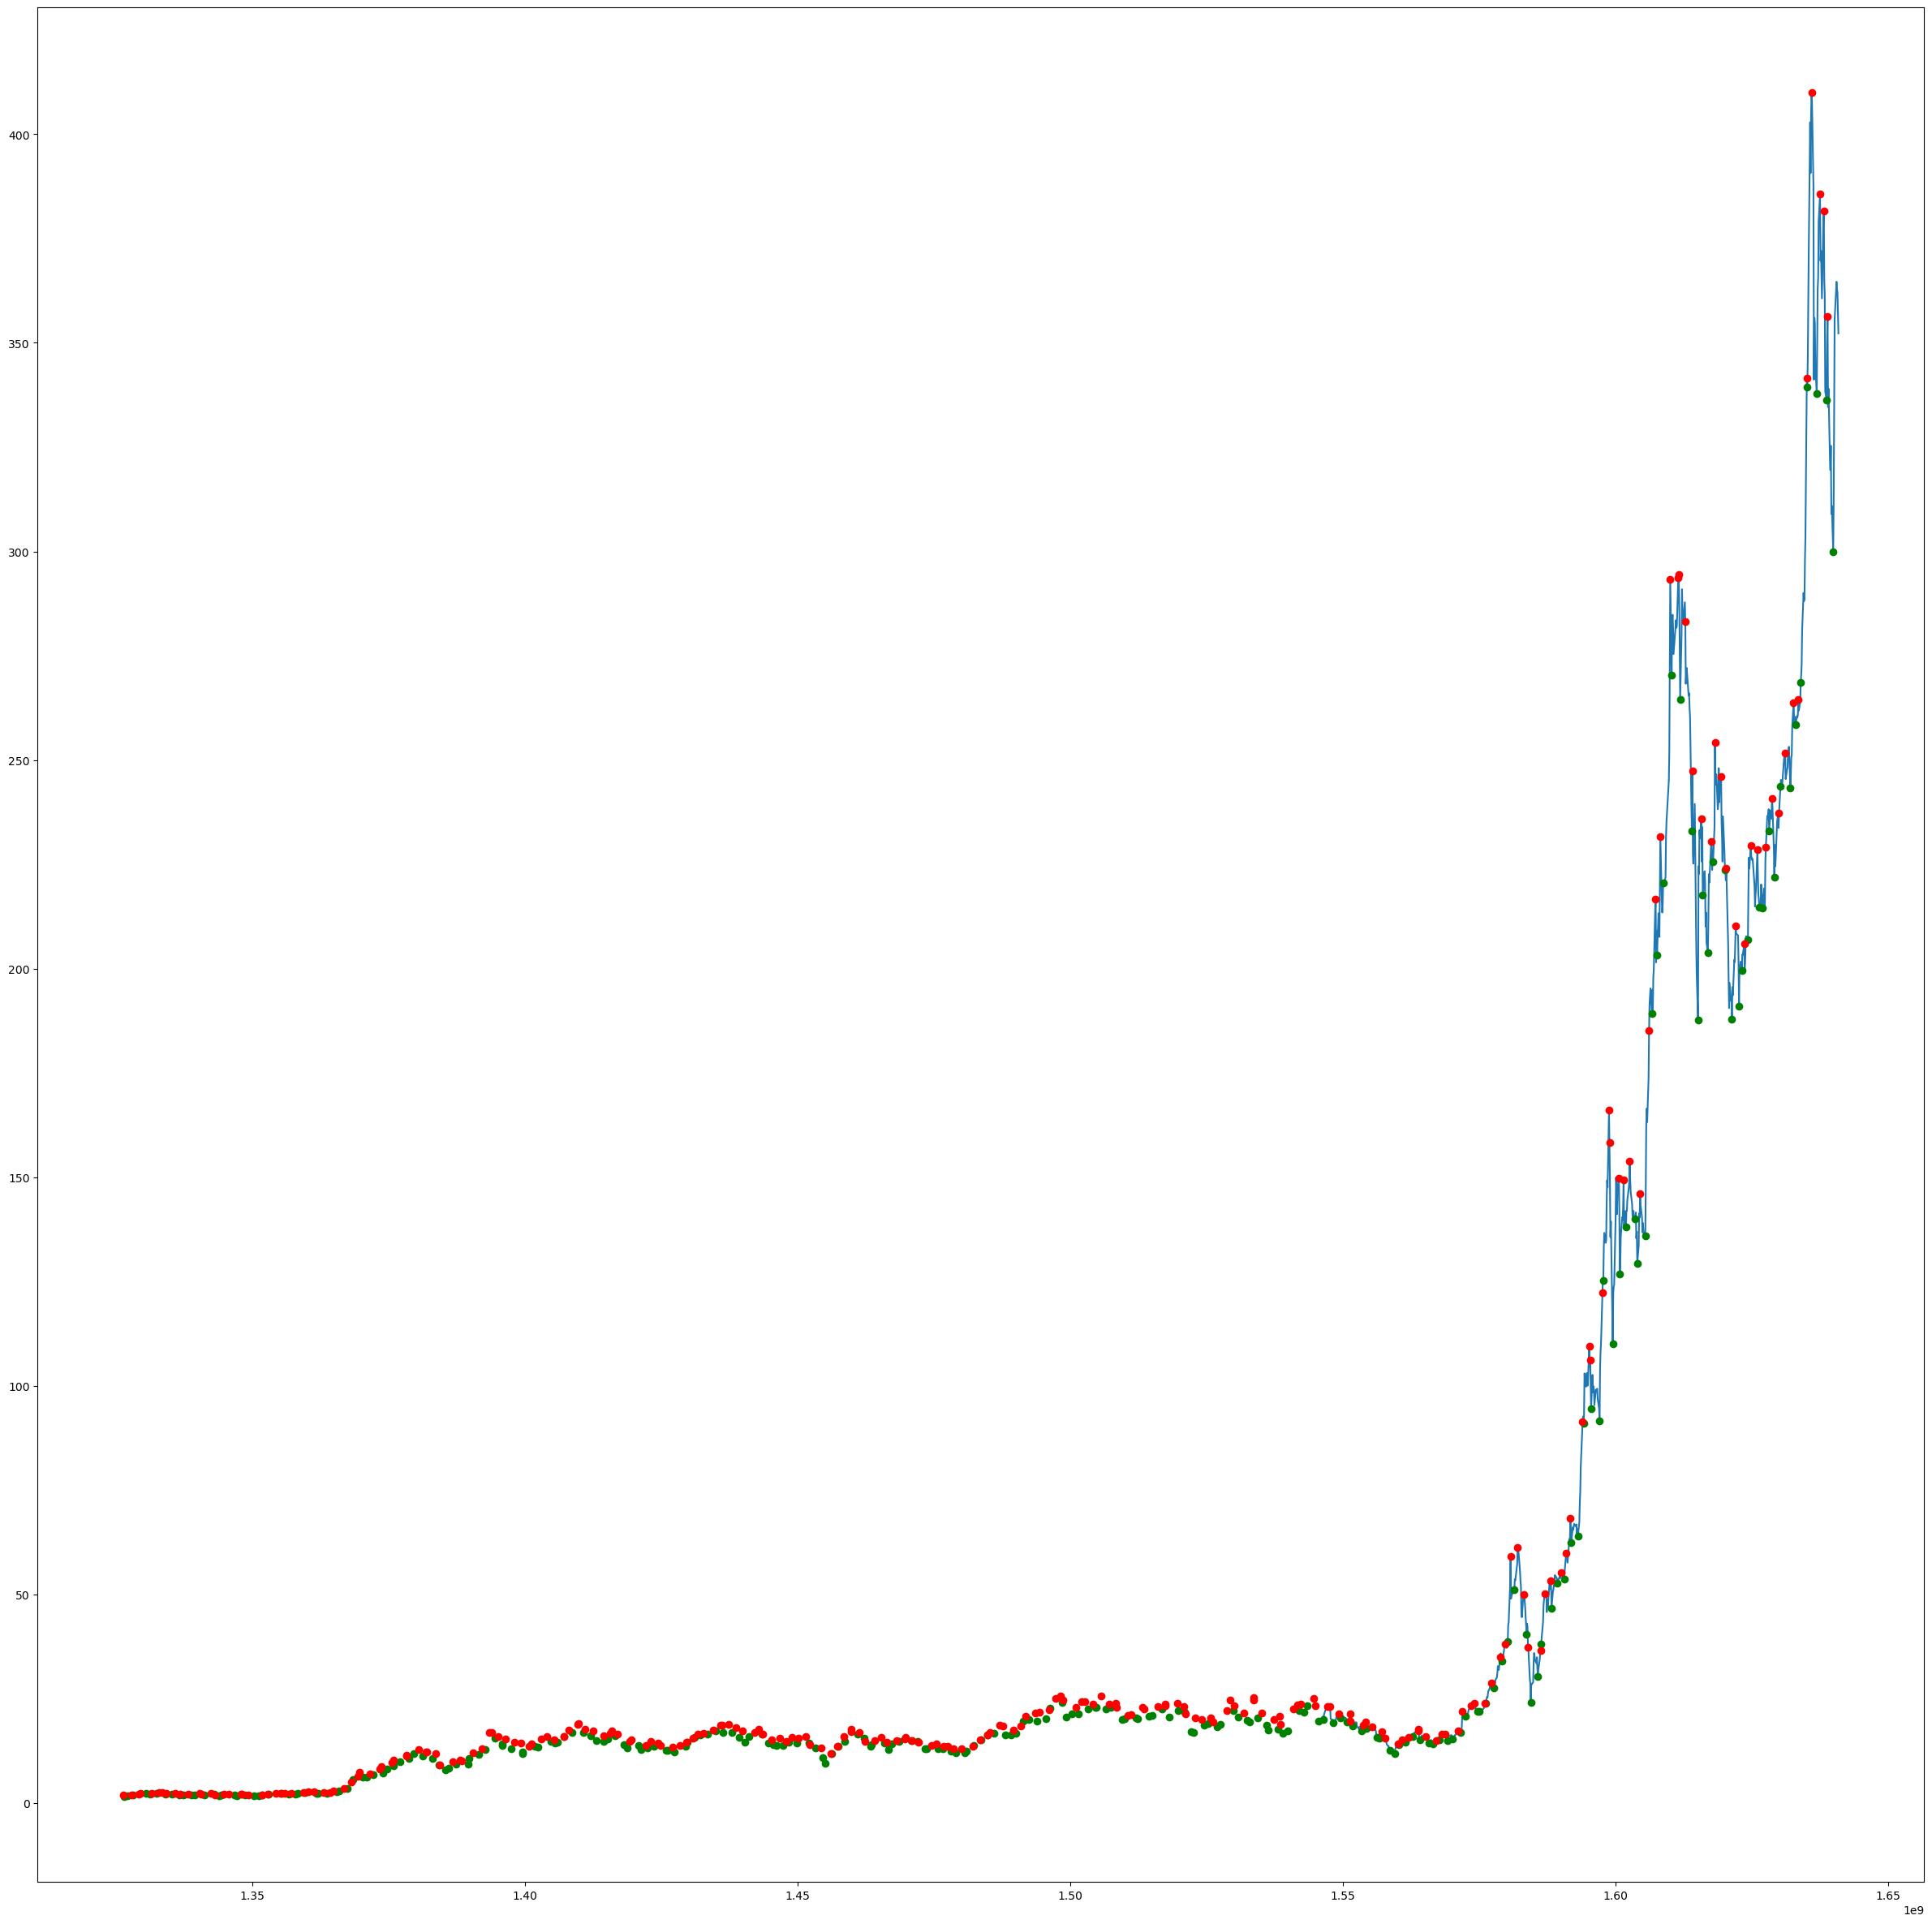

In [14]:
#Time to visualize the maxs and mins
plt.figure(figsize=(30, 30))
plt.plot(stock_df["timestamps"], stock_df["Close"])
plt.plot(min_time, min_prices, 'o', color='g')
plt.plot(max_time, max_prices, 'o', color='r')

In [15]:
# Function to construct a matrix based on minimum and maximum values within specified intervals in a DataFrame
def min_max_matrix(df, interval):
    # Find minimum and maximum values and their corresponding dates within specified intervals
    min_y = mins(df, int(1.5*interval))
    max_y = maxs(df, int(1.5*interval))
    
    # Create an empty DataFrame to store the matrix
    dataframe = pd.DataFrame({})
    
    # Iterate through columns of the DataFrame
    for i in range(len(df.columns)-interval):
        min_or_max = 0  # Indicator for whether the current row corresponds to a minimum or maximum value
        col = list(range(interval+1))  # Column indices for the matrix
        dict_ = {}
        
        # Extract the current row
        row = np.array(df[df.columns[i:i+interval]])
        rowtime = df.columns[i:i+interval]
        row_list = row.tolist()[0]
        
        # Check if the timestamp of the last date in the row corresponds to a minimum value
        if to_timestamp(rowtime[len(rowtime)-1]) in min_y[0]:
            min_or_max = -1
        
        # Check if the timestamp of the last date in the row corresponds to a maximum value
        if to_timestamp(rowtime[len(rowtime)-1]) in max_y[0]:
            min_or_max = 1
        
        # Append the indicator to the row_list
        row_list.append(min_or_max)
        
        # Create a dictionary for the current row
        for j in col:
            dict_[j] = row_list[j]
        
        # Concatenate the dictionary as a row to the main DataFrame
        dataframe = pd.concat([dataframe, pd.DataFrame([dict_])])

    # Return the resulting DataFrame
    return dataframe


In [16]:
matrix_df = min_max_matrix(horizontal_stock_df2(["TSLA"]),10)

In [17]:
matrix_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.872000,1.847333,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,0
0,1.847333,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,0
0,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,0
0,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,1.773333,0
0,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,1.773333,1.784667,0
...,...,...,...,...,...,...,...,...,...,...,...
0,322.136658,319.503326,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,0
0,319.503326,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,0
0,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,362.063324,0
0,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,362.063324,356.779999,0


In [18]:
matrix_df.loc[matrix_df[10]==1]

,0,1,2,3,4,5,6,7,8,9,10
0,1.972000,2.016667,2.076667,2.120000,2.106667,2.128667,2.172000,2.073333,2.099333,2.211333,1
0,2.120000,2.106667,2.128667,2.172000,2.073333,2.099333,2.211333,2.240000,2.278667,2.331333,1
0,2.352667,2.333333,2.354667,2.332000,2.330667,2.343333,2.293333,2.272000,2.493333,2.529333,1
0,2.343333,2.293333,2.272000,2.493333,2.529333,2.523333,2.488667,2.482667,2.438667,2.534000,1
0,2.210667,2.210667,2.129333,2.121333,2.194000,2.232667,2.222667,2.208667,2.252000,2.262667,1
...,...,...,...,...,...,...,...,...,...,...,...
0,244.523331,250.973328,251.289993,251.619995,245.423340,247.666672,248.163330,251.943329,252.330002,253.163330,1
0,258.130005,263.786682,259.186676,260.436676,258.493347,258.406677,260.510010,260.196655,260.916656,264.536682,1
0,288.089996,288.600006,298.000000,303.226654,341.619995,339.476654,345.953339,359.013336,371.333344,402.863342,1
0,303.226654,341.619995,339.476654,345.953339,359.013336,371.333344,402.863342,390.666656,404.619995,409.970001,1


In [19]:
#Make this matrix but for the nasdaq 500 stocks
#This is going to be a HUGE matrix
def stockmatrices():
    returner_df = pd.DataFrame({})
    for stock in nasdaq_df["Symbol"]:
        returner_df = pd.concat([returner_df, min_max_matrix(horizontal_stock_df2([stock]),10)])
    return returner_df

In [20]:
min_max_df = stockmatrices()

ARG: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ALXN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ALXN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker ABC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ABC: No timezone found, symbol may be delisted
Got error from yahoo api for ticker APC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- APC: No timezone found, symbol may be delisted
APOL: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker AVP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AVP: No timezone found, symbol may be delis

Got error from yahoo api for ticker PKI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- PKI: No timezone found, symbol may be delisted
PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker QEP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- QEP: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RHT, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RHT: No timezone found, symbol may be delisted
RAI: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RDC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RDC: No timezone found, symbol may be deliste

In [21]:
min_max_df =min_max_df.dropna()

In [22]:
min_max_df.loc[min_max_df[10]==1]

,0,1,2,3,4,5,6,7,8,9,10
0,57.892353,57.528397,57.878616,57.411610,57.844276,58.421127,58.922478,58.819447,58.791977,59.011761,1
0,59.547401,59.986916,60.041855,60.247871,60.131126,60.357758,60.412685,60.447041,59.842701,60.453903,1
0,59.842701,60.453903,60.426411,60.156807,60.599262,60.537060,60.564709,60.675301,60.772121,60.979507,1
0,60.509384,60.191338,58.732525,59.092049,59.949379,60.011597,60.523235,61.359776,61.442757,62.223999,1
0,61.774632,61.470394,61.235321,61.159279,61.615585,61.629429,61.152370,61.373627,61.677799,61.691628,1
...,...,...,...,...,...,...,...,...,...,...,...
0,52.704865,53.349850,52.677219,52.658798,52.631149,52.981289,52.059879,53.036579,52.870720,53.727634,1
0,51.018677,52.437656,54.695118,55.515175,57.947704,57.809502,58.730911,57.026295,58.647980,58.786190,1
0,57.533070,57.781853,57.256645,57.717358,57.256645,57.339581,58.279419,59.984035,59.495682,61.172661,1
0,60.610592,59.237690,59.716824,60.223598,60.381165,60.307011,61.066990,60.687000,61.493328,61.576729,1


In [23]:
X_min_max = min_max_df.drop(columns=[10])

In [24]:
y_min_max=min_max_df[10]

# Creating the scaler that transforms the data for John Stockton

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_min_max, y_min_max, random_state=0)

# Create scaler instance
X_scaler2 = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler2.fit(X_train2)

# Scale the data
X_train_scaled2 = X_scaler2.transform(X_train2)
X_test_scaled2 = X_scaler2.transform(X_test2)

In [27]:
start_date="2022-01-01"
end_date="2023-01-03"

In [28]:
#Another tester stock
AON = horizontal_stock_df3("AON", start_date, end_date)

# Implementing the buy and sell strategy 

## First buy getting model's predicted mins and maxes

In [29]:
# Function to identify and record minimum and maximum predicted stock prices
def highs_and_lows(ticker, start_date, end_date):
    # Fetch historical stock data using the horizontal_stock_df3 function
    df = horizontal_stock_df3(ticker, start_date, end_date)
    
    # Initialize lists and dictionaries to store relevant information
    min_time = []              # Times of minimum predicted prices
    max_time = []              # Times of maximum predicted prices
    min_price = []             # Minimum predicted prices
    max_price = []             # Maximum predicted prices
    min_pred_percent = []      # Minimum prediction percentages
    max_pred_percent = []      # Maximum prediction percentages
    min_dict = {}              # Dictionary for minimum predictions
    max_dict = {}              # Dictionary for maximum predictions
    
    # Loop through columns in the DataFrame
    for i in range(1, len(df.columns)-11):
        # Extract prices and corresponding dates for a 10-day interval
        prices = df[df.columns[i:i+10]]
        dates = df.columns[i:i+10]
        
        # Check if the prediction is negative for the minimum
        if John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0] < -1 * (0.0):
            min_price.append(df[df.columns[i+9]][0])
            min_time.append(df.columns[i+9])
            min_pred_percent.append(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0])
        
        # Check if the prediction is positive for maximum
        if John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0] > 0.00:
            max_price.append(df[df.columns[i+9]][0])
            max_time.append(df.columns[i+9])
            max_pred_percent.append(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0])

    # Organize the collected information into dictionaries
    max_dict["Max Time"] = max_time
    max_dict["Max Price"] = max_price
    max_dict["Max Prediction Percent"] = max_pred_percent
    
    min_dict["Min Time"] = min_time
    min_dict["Min Price"] = min_price
    min_dict["Min Prediction Percent"] = min_pred_percent
            
    # Return DataFrames constructed from dictionaries
    return (pd.DataFrame.from_dict(min_dict), pd.DataFrame.from_dict(max_dict))
   
        

In [30]:
#Testing out how John Stockton 
aon_low, aon_high=highs_and_lows("AON", start_date, end_date)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


In [31]:
#Buying points
aon_low

,Min Time,Min Price,Min Prediction Percent
0,1642147200,269.368683,-0.209140
1,1642492800,268.610138,-0.221063
2,1642579200,266.590759,-0.240934
3,1642665600,266.216431,-0.221979
4,1642752000,262.443604,-0.225618
...,...,...,...
115,1671609600,300.755920,-0.079782
116,1671696000,297.897491,-0.082882
117,1671782400,298.334198,-0.066157
118,1672128000,298.711365,-0.040178


In [32]:
#Selling points
aon_high

,Max Time,Max Price,Max Prediction Percent
0,1643616000,272.829071,0.043191
1,1643702400,273.194183,0.082533
2,1643788800,274.990417,0.108693
3,1643875200,272.888245,0.083131
4,1643961600,287.504761,0.205010
...,...,...,...
115,1669881600,300.795593,0.006575
116,1669968000,304.477753,0.021020
117,1670227200,306.423035,0.031139
118,1670313600,305.648895,0.033566


In [33]:
#Transpose the tester stock for graphing purposes
AON_T = AON.T.reset_index().drop(0)
AON_T

,index,0
1,1641196800,288.863342
2,1641283200,289.877899
3,1641369600,288.626862
4,1641456000,286.164215
5,1641542400,278.559418
...,...,...
247,1671782400,298.334198
248,1672128000,298.711334
249,1672214400,297.262299
250,1672300800,301.103271


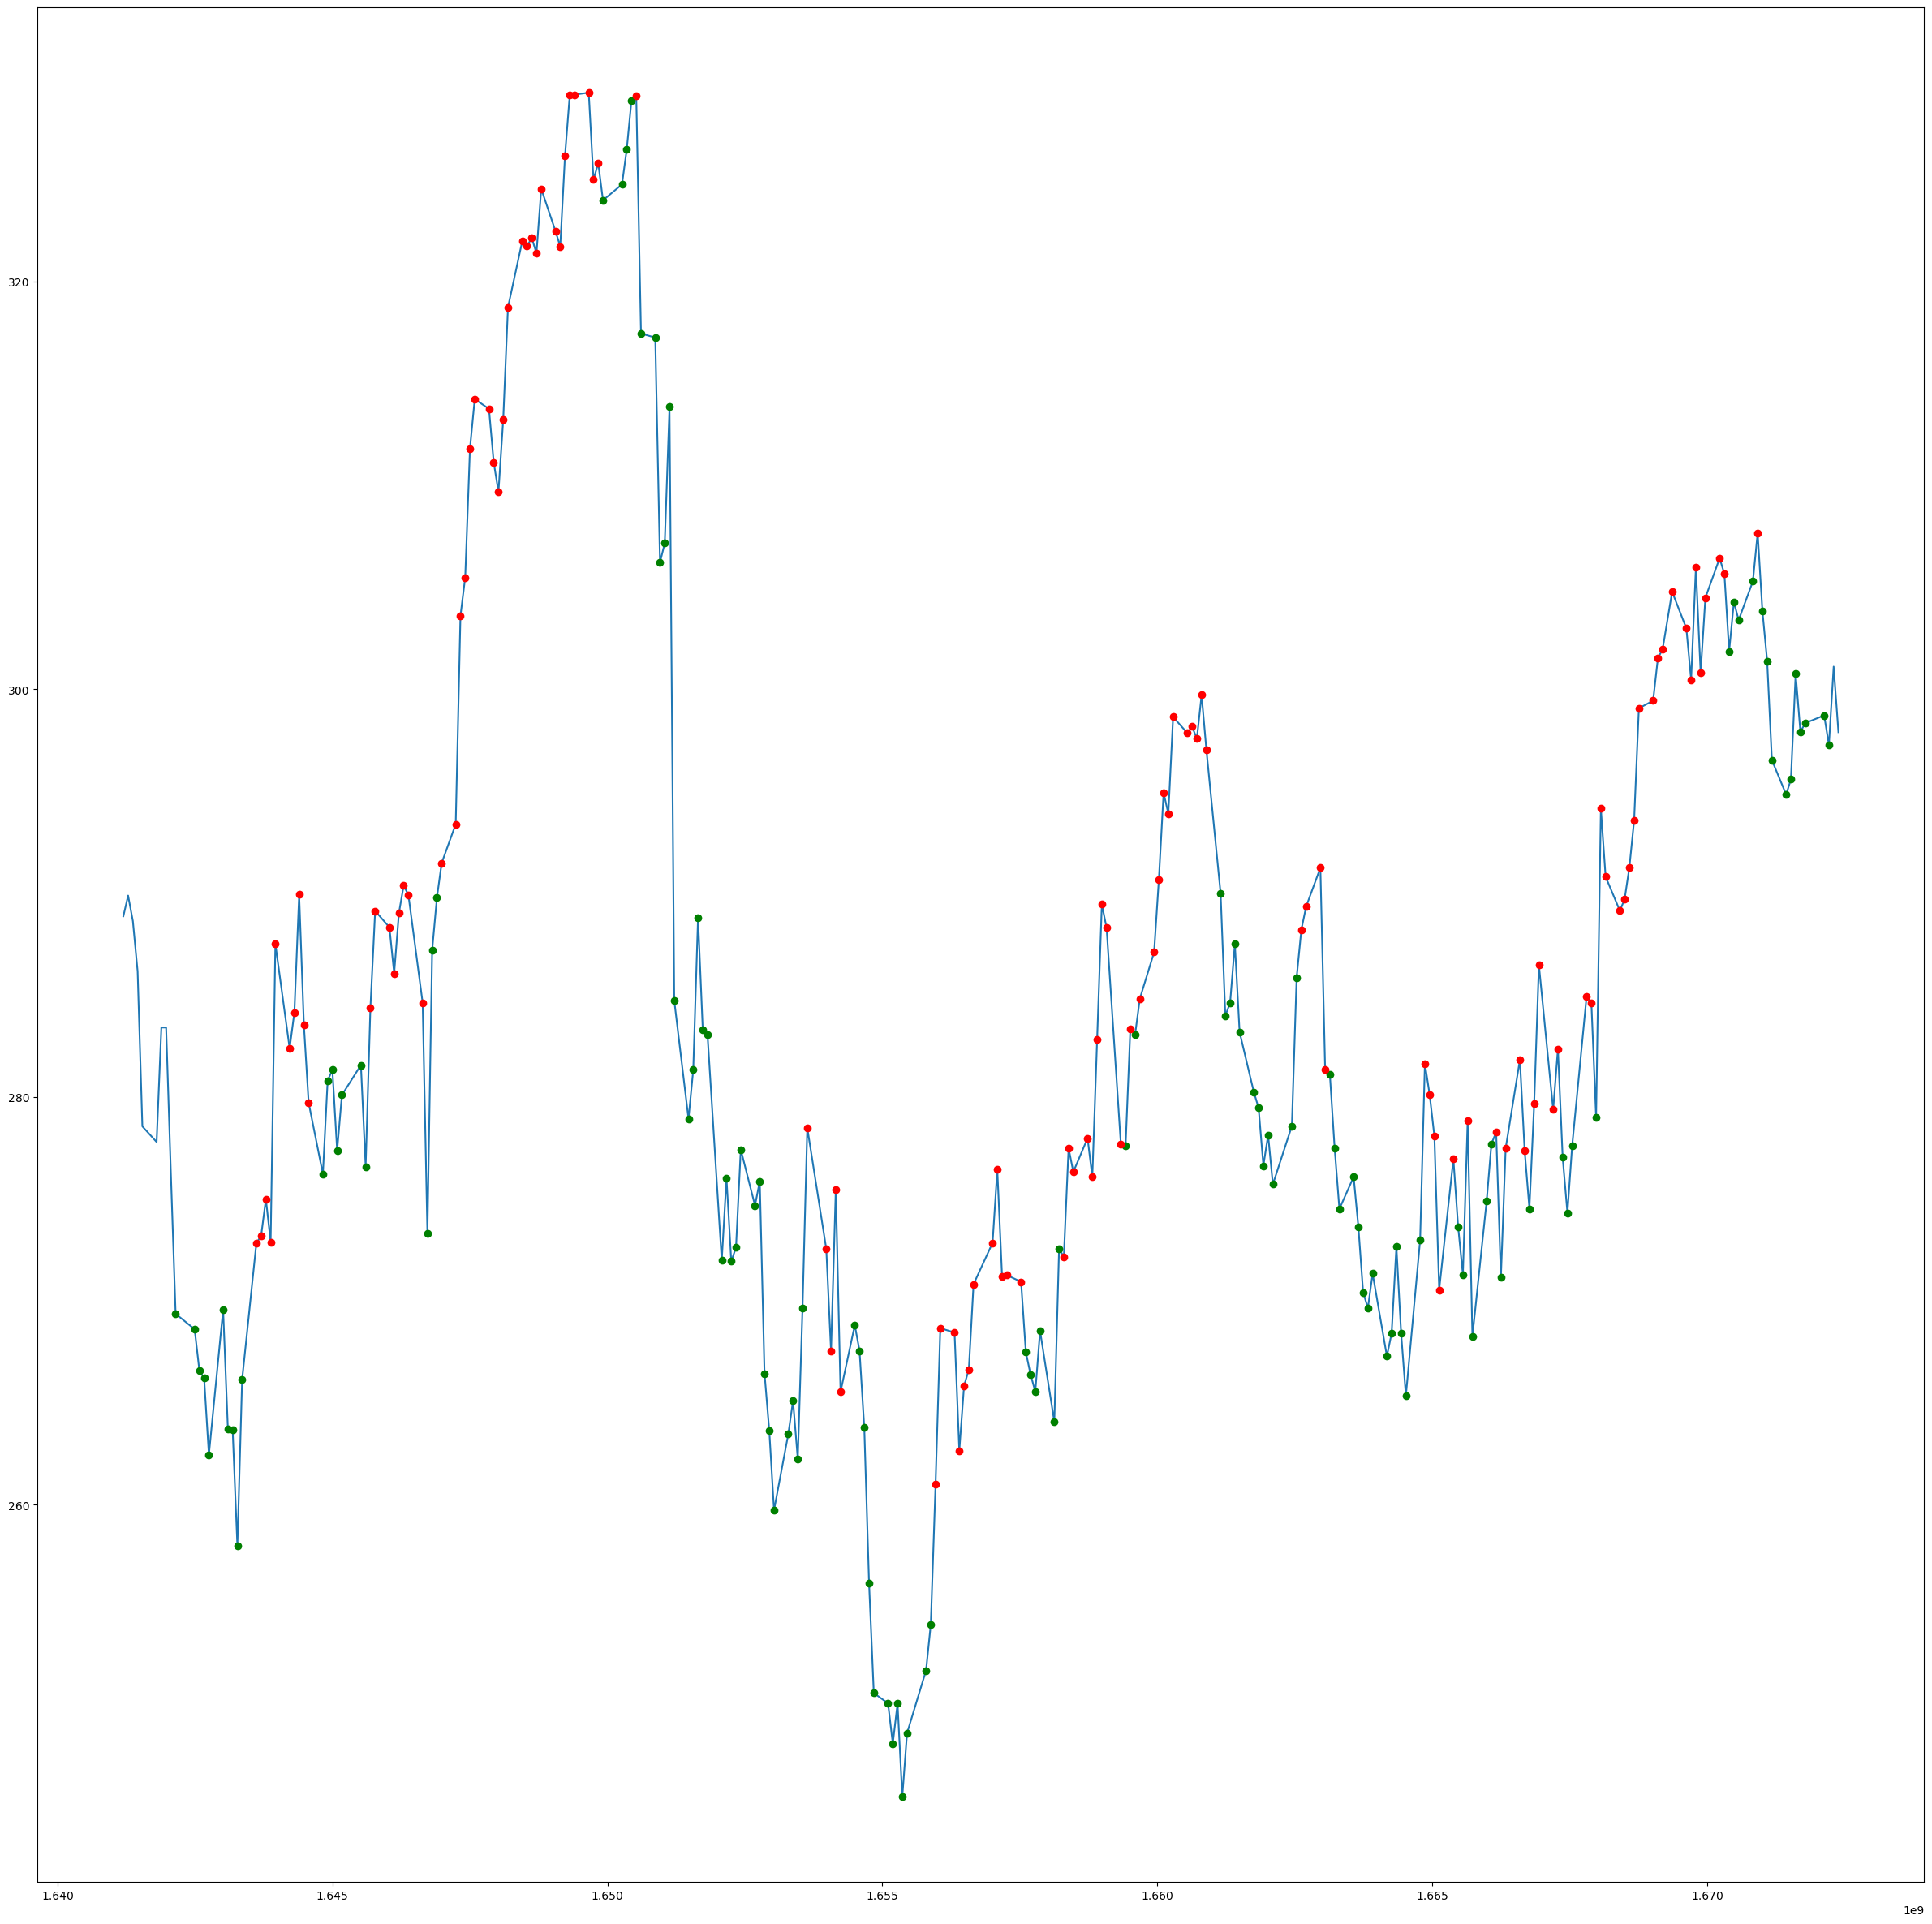

In [34]:
#Sell points represent green. Buy points represent red
plt.figure(figsize=(30, 30))
plt.plot(AON_T["index"], AON_T[0])
plt.plot(aon_low['Min Time'], aon_low["Min Price"], 'o', color="g")
plt.plot(aon_high['Max Time'], aon_high["Max Price"], 'o', color="r")
plt.show()

In [35]:
#Basically what I did with the tester stock but turned into a function
def graph_extrema(ticker):
    low, high=highs_and_lows(ticker, start_date, end_date)
    data = horizontal_stock_df3(ticker, start_date, end_date).T.reset_index().drop(0)
    plt.figure(figsize=(30, 30))
    plt.plot(data["index"], data[0])
    plt.plot(low['Min Time'], low["Min Price"], 'o', color="g")
    plt.plot(high['Max Time'], high["Max Price"], 'o', color="r")
    plt.show()
    
    return low, high

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


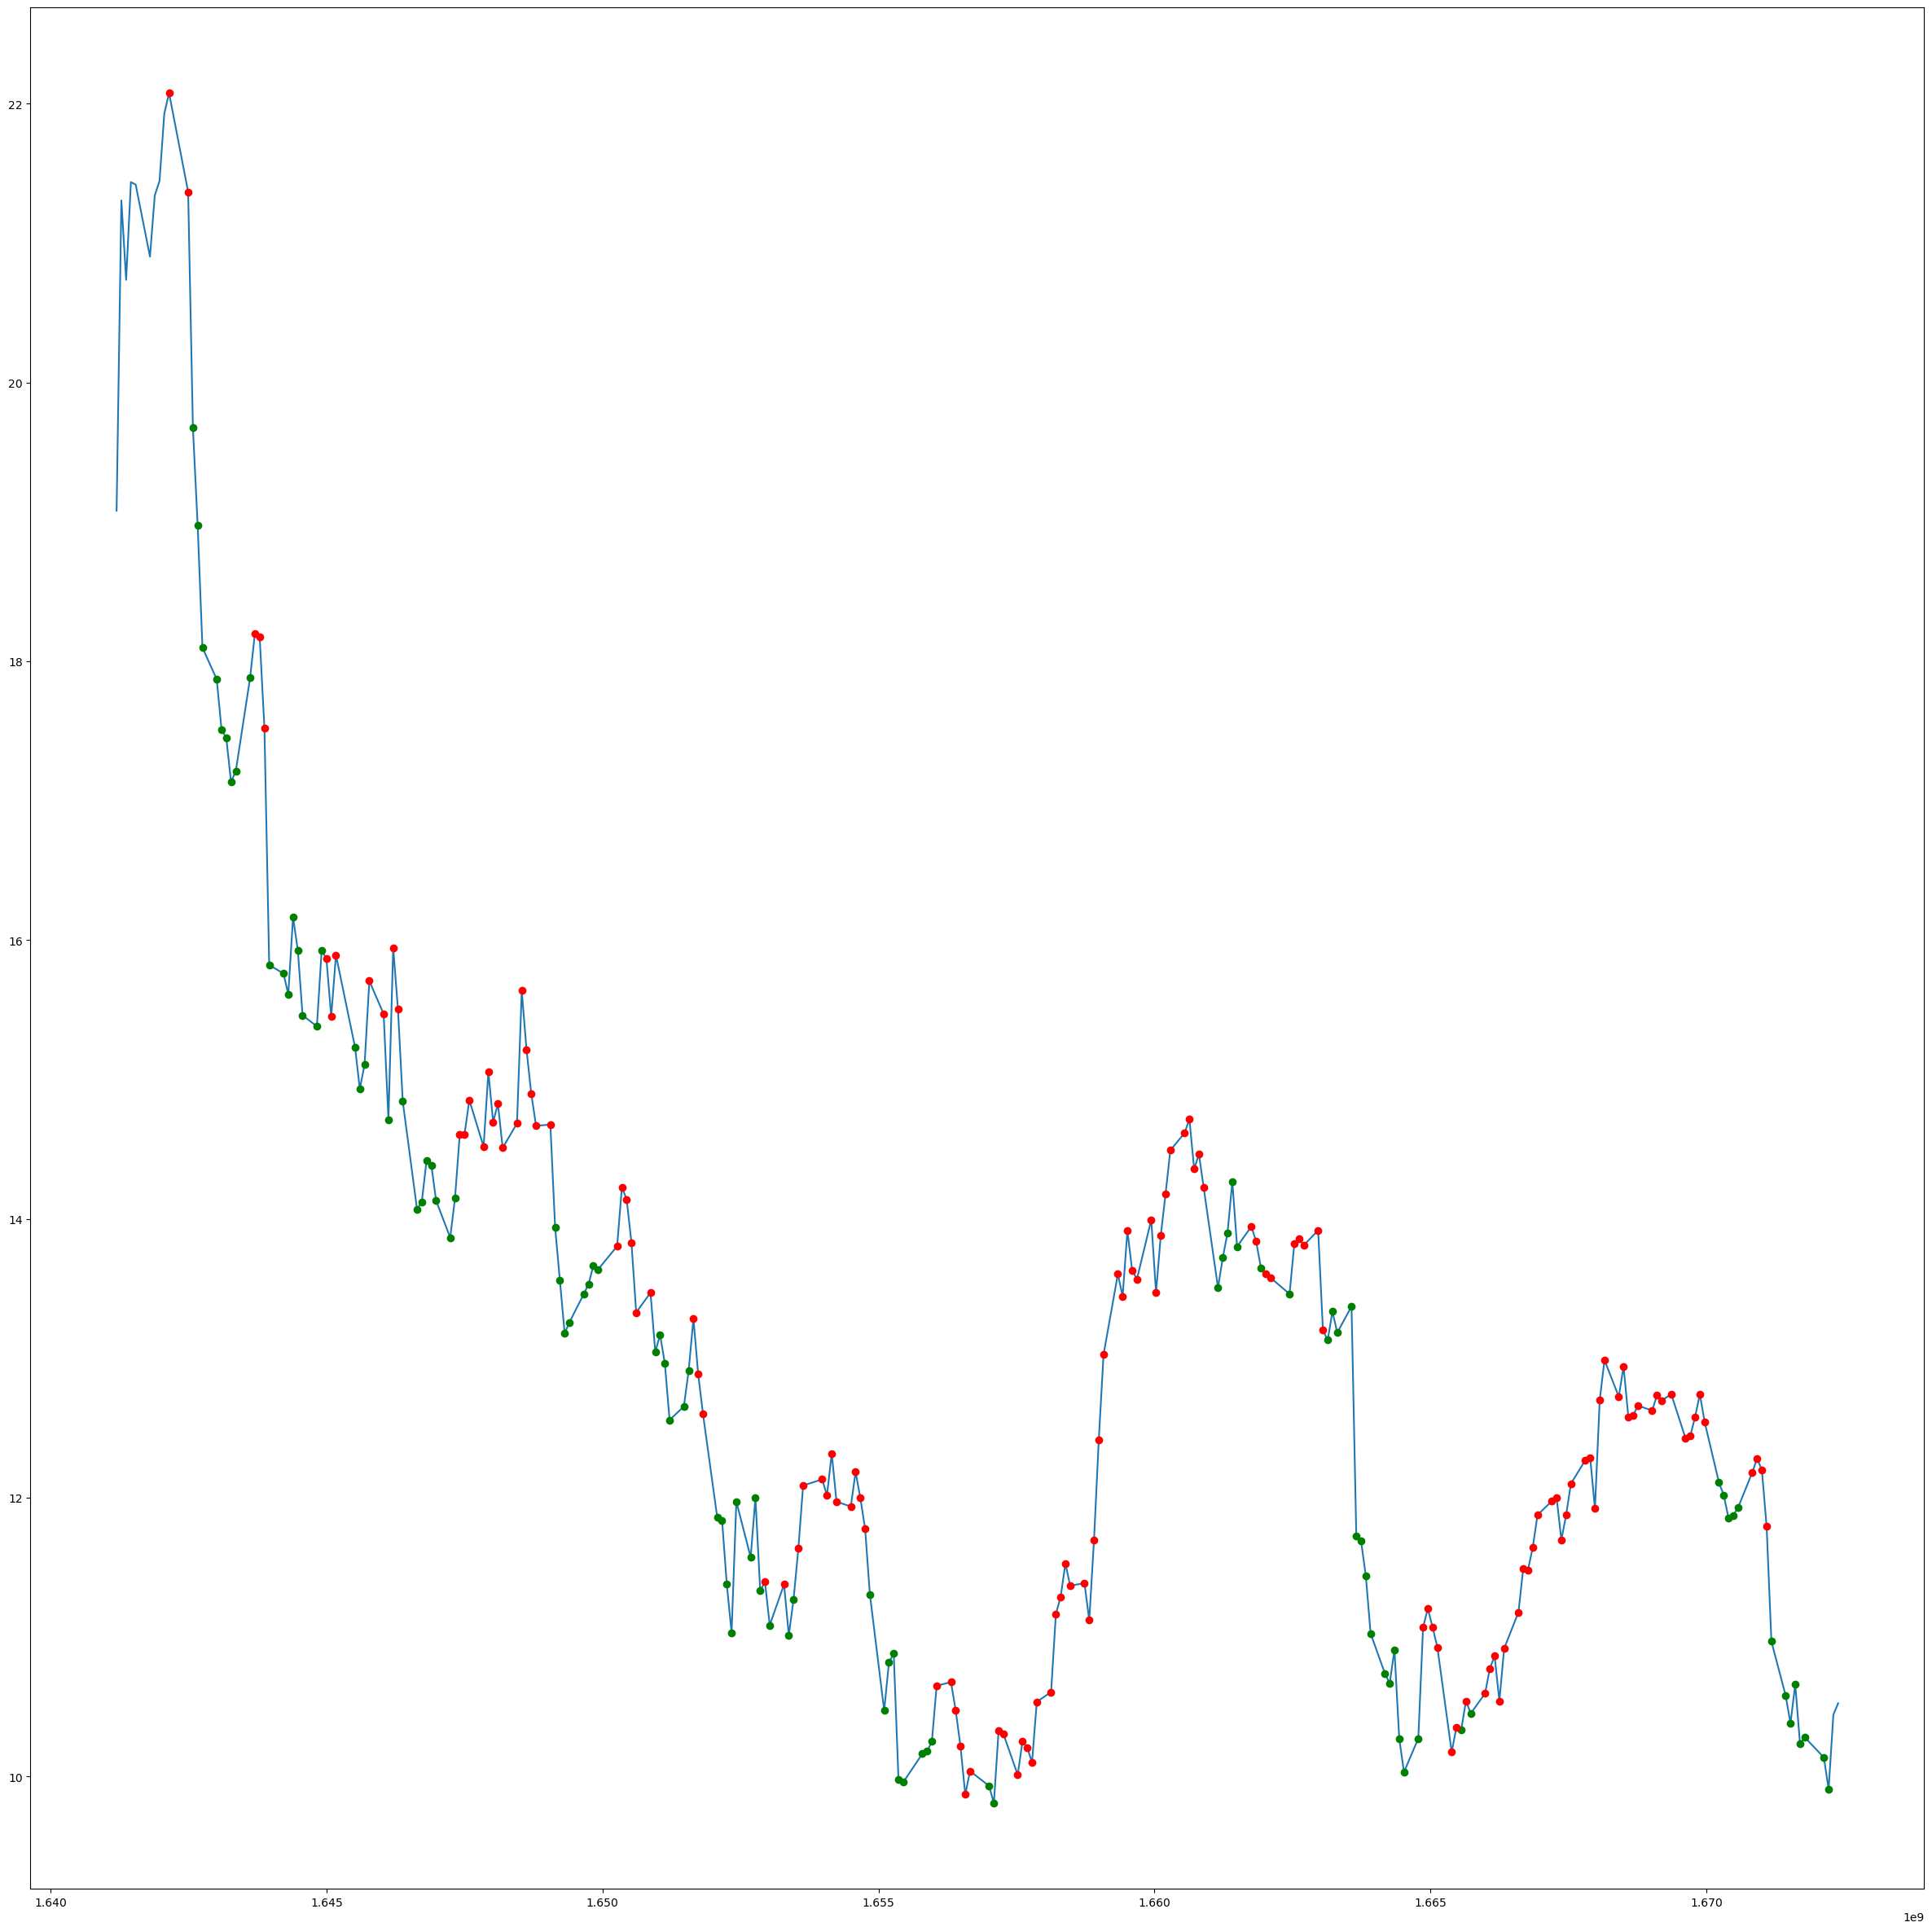

(       Min Time  Min Price  Min Prediction Percent
 0    1642579200  19.675280               -0.018163
 1    1642665600  18.974157               -0.040524
 2    1642752000  18.097754               -0.059700
 3    1643011200  17.869886               -0.068377
 4    1643097600  17.510559               -0.073523
 ..          ...        ...                     ...
 96   1671609600  10.660633               -0.024081
 97   1671696000  10.235294               -0.028570
 98   1671782400  10.280542               -0.023708
 99   1672128000  10.135747               -0.020915
 100  1672214400   9.909502               -0.018329
 
 [101 rows x 3 columns],
        Max Time  Max Price  Max Prediction Percent
 0    1642147200  22.076628                0.027766
 1    1642492800  21.366741                0.014894
 2    1643702400  18.199612                0.000595
 3    1643788800  18.173180                0.012460
 4    1643875200  17.521305                0.007664
 ..          ...        ...          

In [36]:
#Test this with the Ford stock
graph_extrema("F")

# Simulating the buy/sell strategy

In [37]:
# Function to simulate buying and selling actions for a given stock ticker and budget
def buy_sell(ticker, budget):
    # Get high and low points along with predictions for the given stock
    low, high = highs_and_lows(ticker, start_date, end_date)
    
    # Create dictionaries to store information
    dictionary = {}
    return_dict = {}
    
    # Store the original budget for reference
    og_budget = budget
    
    # Initialize variables for shares and price
    shares = 0
    price = 0
    
    # Populate the dictionary with timestamps and corresponding predictions and prices
    for i in range(len(high["Max Time"])):
        dictionary[high["Max Time"][i]] = [high["Max Prediction Percent"][i], high["Max Price"][i]]
    for i in range(len(low["Min Time"])):
        dictionary[low["Min Time"][i]] = [low["Min Prediction Percent"][i], low['Min Price'][i]]
    
    # Sort the dictionary based on timestamps
    dictionary = dict(sorted(dictionary.items()))
    
    # Loop through the timestamps in the sorted dictionary
    for key in dictionary.items():
        price = key[1][1]
        prediction = key[1][0]
        
        # Buy action
        if prediction < 0:
            shares = shares + (budget * -1 * prediction) / price
            budget = budget * (1 + prediction)
        
        # Sell action
        if prediction > 0 and shares > 0:
            budget = budget + (shares * prediction) * price
            shares = shares * (1 - prediction)
    
    # Store the results in the return dictionary
    return_dict["Ticker"] = ticker
    return_dict["Starting Budget"] = og_budget
    return_dict["Shares"] = shares
    return_dict["Amount Accrued"] = budget + shares * price
    
    # Return the results
    return return_dict


In [38]:
 buy_sell("AON", 1000)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


{'Ticker': 'AON',
 'Starting Budget': 1000,
 'Shares': 2.236354252967133,
 'Amount Accrued': 1088.2666387549968}

# Simulating the buy/hold strategy

In [39]:
# Function to simulate a "buy and hold" strategy for a given stock ticker and budget
def buy_hold(ticker, budget):
    # Get historical stock data for the given stock
    stock_data = horizontal_stock_df3(ticker, start_date, end_date).T.reset_index().drop(0)
    
    # Calculate the initial number of shares that can be bought with the budget
    initial_shares = budget / list(stock_data[0])[0]
    
    # Calculate the final amount accrued by holding the shares until the last date in the data
    final_amount = initial_shares * (list(stock_data[0])[len(stock_data) - 1])
    
    # Return the final amount accrued
    return final_amount

In [40]:
buy_hold("AON", 1000)

1031.2407030521033

In [41]:
 buy_hold("F", 1000)

551.6383435030536

# Comparing strategies

In [42]:
# Function to compare the results of "buy and sell" strategy with "buy and hold" strategy for a list of stock tickers and a budget
def buy_sell_vs_hold(tickers, budget):
    # Create an empty DataFrame to store the comparison results
    comparison_df = pd.DataFrame({})
    
    # Loop through the list of tickers
    for ticker in tickers:
        # Simulate "buy and sell" strategy and get the results
        data_dict = buy_sell(ticker, budget)
        
        # Calculate the result of "buy and hold" strategy for the same stock
        data_dict["Buy and Hold Total"] = buy_hold(ticker, budget)
        
        # Concatenate the dictionary as a row to the main DataFrame
        comparison_df = pd.concat([comparison_df, pd.DataFrame([data_dict])])
    
    # Return the DataFrame containing the comparison results
    return comparison_df

In [43]:
#Grab stocks that the neural network thought were going to make a profit from John Stockton.ipynb
stonkies = open("chosen_stocks.txt", "r")

In [44]:
#Grab the tickers only
test_stocks=[]
for line in stonkies:
    test_stocks.append(line.split("\t")[1])
test_stocks

['UNH',
 'MA',
 'HD',
 'AVGO',
 'COST',
 'TMO',
 'ACN',
 'ADBE',
 'NFLX',
 'AMGN',
 'INTU',
 'LMT',
 'BA',
 'DE',
 'SPGI',
 'ELV',
 'GS',
 'SYK',
 'BLK',
 'BKNG',
 'AMT',
 'REGN',
 'VRTX',
 'CI',
 'LRCX',
 'NOC',
 'BDX',
 'AON',
 'EQIX',
 'HUM',
 'MELI',
 'APD',
 'CHTR',
 'FDX',
 'MCO',
 'PSA',
 'ORLY',
 'ROP',
 'CMG',
 'CTAS',
 'MSCI',
 'AZO',
 'IDXX',
 'STZ']

In [45]:
#Compare buying and holding with the test stocks for $10,000 on each stock
comparison_df = buy_sell_vs_hold(test_stocks, 10000)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


In [46]:
comparison_df=comparison_df.rename(columns={"Amount Accrued": "John Stockton"})
comparison_df

,Ticker,Starting Budget,Shares,John Stockton,Buy and Hold Total
0,UNH,10000,8.895636,11408.438132,10690.648301
0,MA,10000,19.528767,10987.714926,9428.962968
0,HD,10000,19.634570,9949.419199,7924.005863
0,AVGO,10000,1.031295,10876.183007,8700.361779
0,COST,10000,19.449644,9452.066379,8109.161206
0,TMO,10000,9.957132,11512.860069,8557.758753
0,ACN,10000,36.017701,9626.023874,6642.281723
0,ADBE,10000,13.175963,9712.352685,5962.932149
0,NFLX,10000,27.317732,8311.752310,4936.304255
0,AMGN,10000,41.008850,11210.873444,11951.813504


# Visualization of the comparison

<AxesSubplot:>

<Figure size 3000x3000 with 0 Axes>

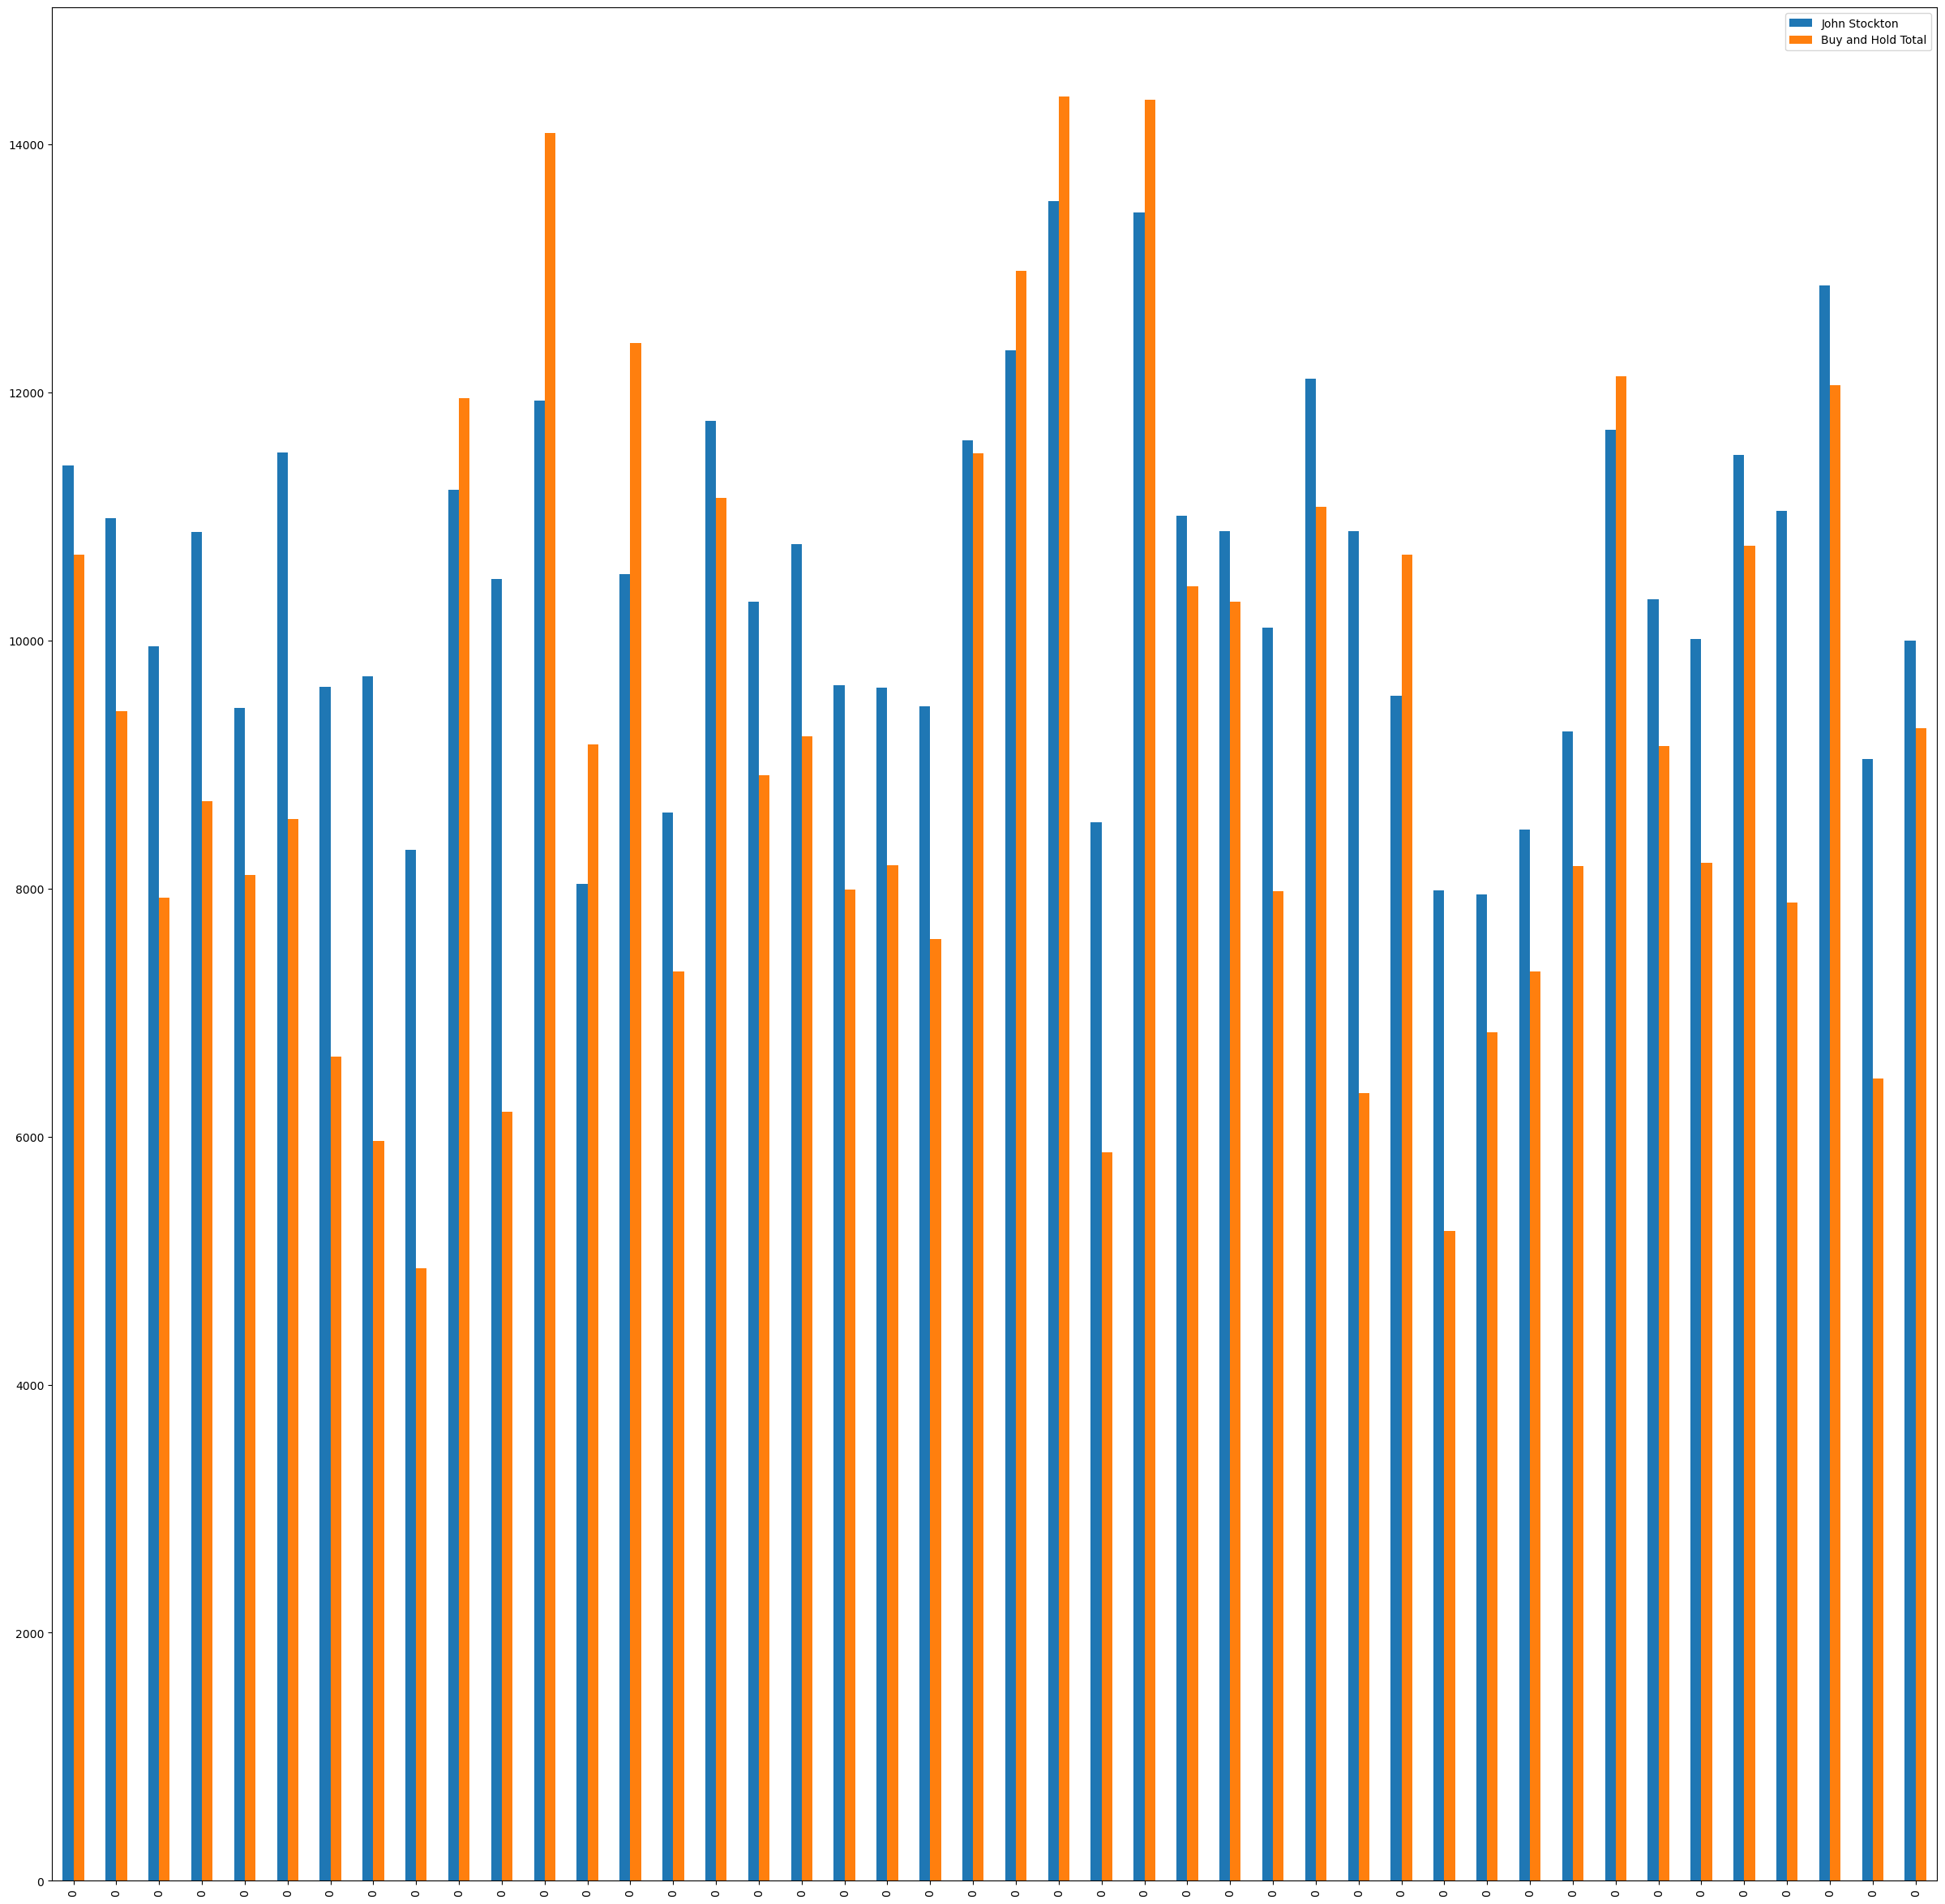

In [47]:
#Visualize the difference

#The orange is buying and holding
#The blue is John Stockton
plt.figure(figsize=(30, 30))
comparison_df[["John Stockton","Buy and Hold Total"]].plot.bar(rot=90,figsize=(30, 30))

In [48]:
#The agrregate sum
comparison_df.agg('sum')

Ticker                UNHMAHDAVGOCOSTTMOACNADBENFLXAMGNINTULMTBADESP...
Starting Budget                                                  440000
Shares                                                       723.137121
John Stockton                                              458411.72395
Buy and Hold Total                                        404624.507688
dtype: object

In [49]:
#Testing if there is a significant difference between buying and holding and the John Stockton Model
stats.ttest_ind(comparison_df["John Stockton"], comparison_df["Buy and Hold Total"])

Ttest_indResult(statistic=2.8524676801033153, pvalue=0.005432233807421783)

# Conclusion

In conclusion, the project aimed to develop a stock prediction model and compare its performance with a traditional buy and hold strategy. The John Stockton Model was trained on historical stock data, and its predictions were compared with the results of a buy and hold strategy for a selected set of stocks. 

Based on the comparison with 44 tested stocks, John Stockton seems be better at minimizing losses rather than maximizing profits. The buy/hold strategy only seems to outperform the John Stockton Model only mostly on unusually high returns on the stocks.

Statistical tests were conducted to assess the significance of the differences between the two strategies, and with a p-value of 0.005, one can conclude that John Stockton is significantly different from buying and holding. However, with the return on investment on aggregate leading to a profit with John Stockton versus a loss with buying and holding. One can conclude that John Stockton is better financially than buying and holding stocks. 

For future versions, I want to construct the same model for daily trades and even for cryptocurrency.